# This is a document that tries keras on jupyter notebook

## Several notes for 11.17
1. Normalizing input data is essential
2. for categorical result, even though there are only two categories, use multi output and softmax. This is necessary as for calculating output in real cases, there are more variables to compare to, thus higher security of a good result.
3. From my guesses, using BN after concatenating two different vectors might alleviate the fitting effort during training, but this remain to be seen
4. Design the network structure with your heart, dude!

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
import re
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
import time
%matplotlib notebook

Using TensorFlow backend.


In [48]:
# visualization tool
class RealTimeVisualizer(Callback):
    def on_train_begin(self, logs={}):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2,1, sharex=True)
        self.fig.set_size_inches(20, 8)
        self.index_graph = []
        self.loss_graph = []
        self.val_loss_graph = []
        self.acc_graph = []
        self.val_acc_graph = []
 
    def on_epoch_end(self, epoch, logs={}):
        interval = self.interval
        loss = logs['loss']
        val_loss = logs['val_loss']
        val_acc = logs['val_acc']
        acc = logs['acc']
        if epoch%interval == interval-1:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc
            self.loss_graph[int(epoch/interval)] /= interval
            self.val_loss_graph[int(epoch/interval)] /= interval
            self.val_acc_graph[int(epoch/interval)] /= interval
            self.acc_graph[int(epoch/interval)] /= interval
            self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
            self.ax1.plot(self.index_graph, self.loss_graph, '-r')
            self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
            self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
            self.ax2.plot(self.index_graph, self.acc_graph, '-r')
            self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
            self.ax2.plot(self.index_graph, [0.5]*len(self.index_graph), '-p')
            self.fig.canvas.draw()
            time.sleep(0.05)
        elif epoch%interval == 0:
            self.loss_graph.append(loss)
            self.val_loss_graph.append(val_loss)
            self.val_acc_graph.append(val_acc)
            self.acc_graph.append(acc)
            self.index_graph.append(epoch)
        else:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc

VisualizeCallback = RealTimeVisualizer()
VisualizeCallback.interval = 20

In [3]:
def is_desired_letter(char):
    return ord(char) >= 97 and ord(char) < 123 or ord(char) >= 48 and ord(char) < 58 or ord(char) == ord(" ")


# return even number of 0 and 1 if is_even_result is True
def get_train_data(train_portion, is_even_result=True):
    # load the dataset but only keep the top n words, zero the rest
    train_data = pd.read_csv("input/kickstarter_train.csv")
    train_texts_and_results = train_data.iloc[:, [2, -1]]
    # do preliminary preprocessing:remove all symbols
    train_data["desc"] = [[char for char in str(text).lower() if is_desired_letter(char)] for
                          text in train_data["desc"]]
    # load pretrained bigram and extract phrases
    bigram = Phrases.load("my_bigram_with_vocab_15941.pkl")
    train_data["desc"] = [bigram[text] for text in train_data["desc"]]
    train_data["desc"] = [''.join(text).split() for text in train_data["desc"]]
    # remove too short desc
    drop_index = []
    for i in range(len(train_data)):
        if len(train_data.iloc[i, 2]) <= 3:
            drop_index.append(i)
    train_data = train_data.drop(train_data.index[drop_index])
    
    if is_even_result:
        # count 0 and drop some until sample of 1 = sample of 0
        status_count = train_data.iloc[:, -1].value_counts().to_dict()
        drop_zero_num = status_count[0] - status_count[1]
        drop_zero_p = drop_zero_num / float(status_count[0])
        drop_index = []
        for i in range(len(train_data)):
            if train_data.iloc[i, -1] == 0:
                if np.random.uniform(low=0, high=1) < drop_zero_p:
                    drop_index.append(i)
        train_data = train_data.drop(train_data.index[drop_index])
        status_count = train_data.iloc[:, -1].value_counts().to_dict()
        print(float(status_count[0]) / float(status_count[1]))
        # shuffle the whole data
        train_data = train_data.sample(frac=1).reset_index(drop=True)
    
    # spliting input output
    # get split point for train and test data
    split_point = int(train_portion * len(train_data))
    # get descriptions data
    train_texts = np.array(train_data.iloc[:split_point, 2])
    test_texts = np.array(train_data.iloc[split_point:, 2])
    # get num data
    train_num = np.array(train_data.iloc[:split_point, [3, 12]])
    test_num = np.array(train_data.iloc[split_point:, [3, 12]])
    # get result data
    train_results = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[:split_point, -1]])
    test_results = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[split_point:, -1]])
    
    return train_texts, train_num, train_results, test_texts, test_num, test_results


def get_bad_word_portion(data, all_words):
    bad_word_num = 0.0
    all_word = 0.0
    for text in data:
        for word in text:
            all_word += 1
            if word not in all_words:
                bad_word_num += 1
    return bad_word_num / all_word


def convert_to_onehot(data, num_features):
    new_data = []
    for item in data:
        new_data.append(np_utils.to_categorical(item, num_classes=num_features))
    return np.array(new_data)

In [4]:
# get training testing data from disk
train_data_portion = 0.8
trainX_desc, trainX_num, trainY, testX_desc, testX_num, testY = get_train_data(train_data_portion)
print("data grabbed")
print(len(trainX_desc))
print(len(testY))

/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


1.0015177667995954
data grabbed
53804
13451


In [5]:
# convert word to int with loaded pretrained dictionary
word_to_int = Dictionary.load("dictionary_least_dfs_8_vocab_13152.pkl")
n_vacab = len(word_to_int)
trainX_desc = [[word_to_int.token2id[word] for word in text 
                if word in word_to_int.token2id] for text in trainX_desc]
# print bad word portion for test data before tokenization
print("word that is not in dictionary", get_bad_word_portion(testX_desc, word_to_int.token2id))
testX_desc = [[word_to_int.token2id[word] for word in text if word in word_to_int.token2id] for text in testX_desc]
print("tokenizing and normalizing is done")

# output statistic of desc's
length_list = np.array([len(item) for item in trainX_desc])
print("length of all data is: \n max {}, min {} and mean {}".format(
        length_list.max(), length_list.min(), length_list.mean()))

word that is not in dictionary 0.06312063673567646
tokenizing and normalizing is done
length of all data is: 
 max 35, min 2 and mean 18.57584937922831


In [6]:
# preprocessing description data
# truncate and pad input sequences
max_desc_length = 35
trainX_desc = sequence.pad_sequences(list(trainX_desc), maxlen=max_desc_length, truncating="post")
testX_desc = sequence.pad_sequences(list(testX_desc), maxlen=max_desc_length, truncating="post")
print("padding finished")

padding finished


In [7]:
# preprocessing input nums
def preprocess_num_data(data_num, scale=1):
    data_num_0 = [float(item[0]) for item in data_num]
    data_num_1 = [float(item[1]) for item in data_num]
    max0 = np.array(data_num_0).max()
    max1 = np.array(data_num_1).max()
    data_num_0 = [(item / max0 * 2 - 1)*scale for item in data_num_0]
    data_num_1 = [(item / max1 * 2 - 1)*scale for item in data_num_1]
    data_num= list(zip(data_num_0, data_num_1))
    data_num = np.array(data_num)
    return data_num

trainX_num = preprocess_num_data(trainX_num, 1)
testX_num = preprocess_num_data(testX_num, 1)
print("number has been converted to a smaller region")

number has been converted to a smaller region


In [8]:
# generate model for descriptions
model_input = Input(shape=(35,))
x = model_input
x = Embedding(input_dim=n_vacab, output_dim=256, input_length=35, name="embedding")(x)
x = GaussianNoise(stddev=0.1)(x)
x = LSTM(units=64, return_sequences=True, dropout=0.2)(x)
x = LSTM(units=64, dropout=0.2)(x)
x = GaussianNoise(stddev=0.1)(x)
x = Dropout(0.25)(x)
x = Dense(128, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation("tanh")(x)
x = Dropout(0.25)(x)
x = Dense(128, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation("tanh")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
description_model = Model(inputs=[model_input], outputs=[x])

# load pretrained embedding layer and freeze it
description_model.load_weights("embedding_layer_acc0.7512.h5", by_name=True)
description_model.layers[1].trainable = False
# configurate model training
description_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
print("model building finished\n", description_model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding (Embedding)        (None, 35, 256)           3366912   
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 35, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 64)            82176     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 64)                0      

In [37]:
# do training
epoch_num = 5
for i in range(epoch_num):
    description_model.fit(trainX_desc, trainY, epochs=20, batch_size=512, shuffle=True,
                      verbose=1, validation_data=[testX_desc, testY], callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)])
    # see actual result
    scores = description_model.evaluate(testX_desc, testY, verbose=1)
    print("Accuracy:{}".format(np.array(scores)))
    print("actual epoch num is: ", i)

# save model
filepath = "description_model_weights.h5"
description_model.save_weights(filepath)

Train on 53673 samples, validate on 13419 samples
Epoch 1/20
53673/53673 [==============================] - 28s 530us/step - loss: 1.7314 - acc: 0.5178 - val_loss: 0.9975 - val_acc: 0.5023
Epoch 2/20
53673/53673 [==============================] - 25s 469us/step - loss: 0.8612 - acc: 0.5446 - val_loss: 0.7556 - val_acc: 0.4977
Epoch 3/20
53673/53673 [==============================] - 26s 480us/step - loss: 0.7360 - acc: 0.5578 - val_loss: 0.6996 - val_acc: 0.5838
Epoch 4/20
53673/53673 [==============================] - 25s 471us/step - loss: 0.7011 - acc: 0.5665 - val_loss: 0.6797 - val_acc: 0.5951
Epoch 5/20
53673/53673 [==============================] - 26s 489us/step - loss: 0.6873 - acc: 0.5797 - val_loss: 0.6681 - val_acc: 0.6030
Epoch 6/20
53673/53673 [==============================] - 27s 502us/step - loss: 0.6795 - acc: 0.5837 - val_loss: 0.6657 - val_acc: 0.5988
Epoch 7/20
53673/53673 [==============================] - 25s 468us/step - loss: 0.6706 - acc: 0.5947 - val_loss: 0.

In [66]:
# generate autoencoding model for num data
model_input = Input(shape=(2,))
x = model_input
x = Dense(units=128, kernel_regularizer=l1(0.01), name="num_dense_1")(x)
x = Activation("tanh")(x)
# x = Dropout(0.25)(x)
x = Dense(units=128, kernel_regularizer=l1(0.01), name="num_dense_2")(x)
x = BatchNormalization(name="num_bn_1")(x)
x = Activation("tanh")(x)
# x = Dropout(0.25)(x)
x = Dense(units=2, activation="tanh")(x)
num_model = Model(inputs=[model_input], outputs=[x])

# configure network for training
num_model.compile(loss='mse', optimizer="adam", metrics=["mse"])
print("model building finished\n", num_model.summary())

# do training
num_model.fit(trainX_num, trainX_num, epochs=100, batch_size=256, shuffle=True,
                  verbose=1, validation_data=[testX_num, testX_num], callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
num_dense_1 (Dense)          (None, 128)               384       
_________________________________________________________________
activation_28 (Activation)   (None, 128)               0         
_________________________________________________________________
num_dense_2 (Dense)          (None, 128)               16512     
_________________________________________________________________
num_bn_1 (BatchNormalization (None, 128)               512       
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 258       
Total para

In [67]:
# generate pretrain model for num data
num_model.layers.pop()
x = Dense(units=2, activation="softmax")(num_model.layers[-1].output)
num_model = Model(inputs=[num_model.layers[0].input], outputs=[x])

# Plot things out can really help!!!
> This happens when your math cannot help you understand the situation. 
> This will work if your graph intuition is good

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
num_dense_1 (Dense)          (None, 128)               384       
_________________________________________________________________
activation_28 (Activation)   (None, 128)               0         
_________________________________________________________________
num_dense_2 (Dense)          (None, 128)               16512     
_________________________________________________________________
num_bn_1 (BatchNormalization (None, 128)               512       
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 258       
Total para

<IPython.core.display.Javascript object>


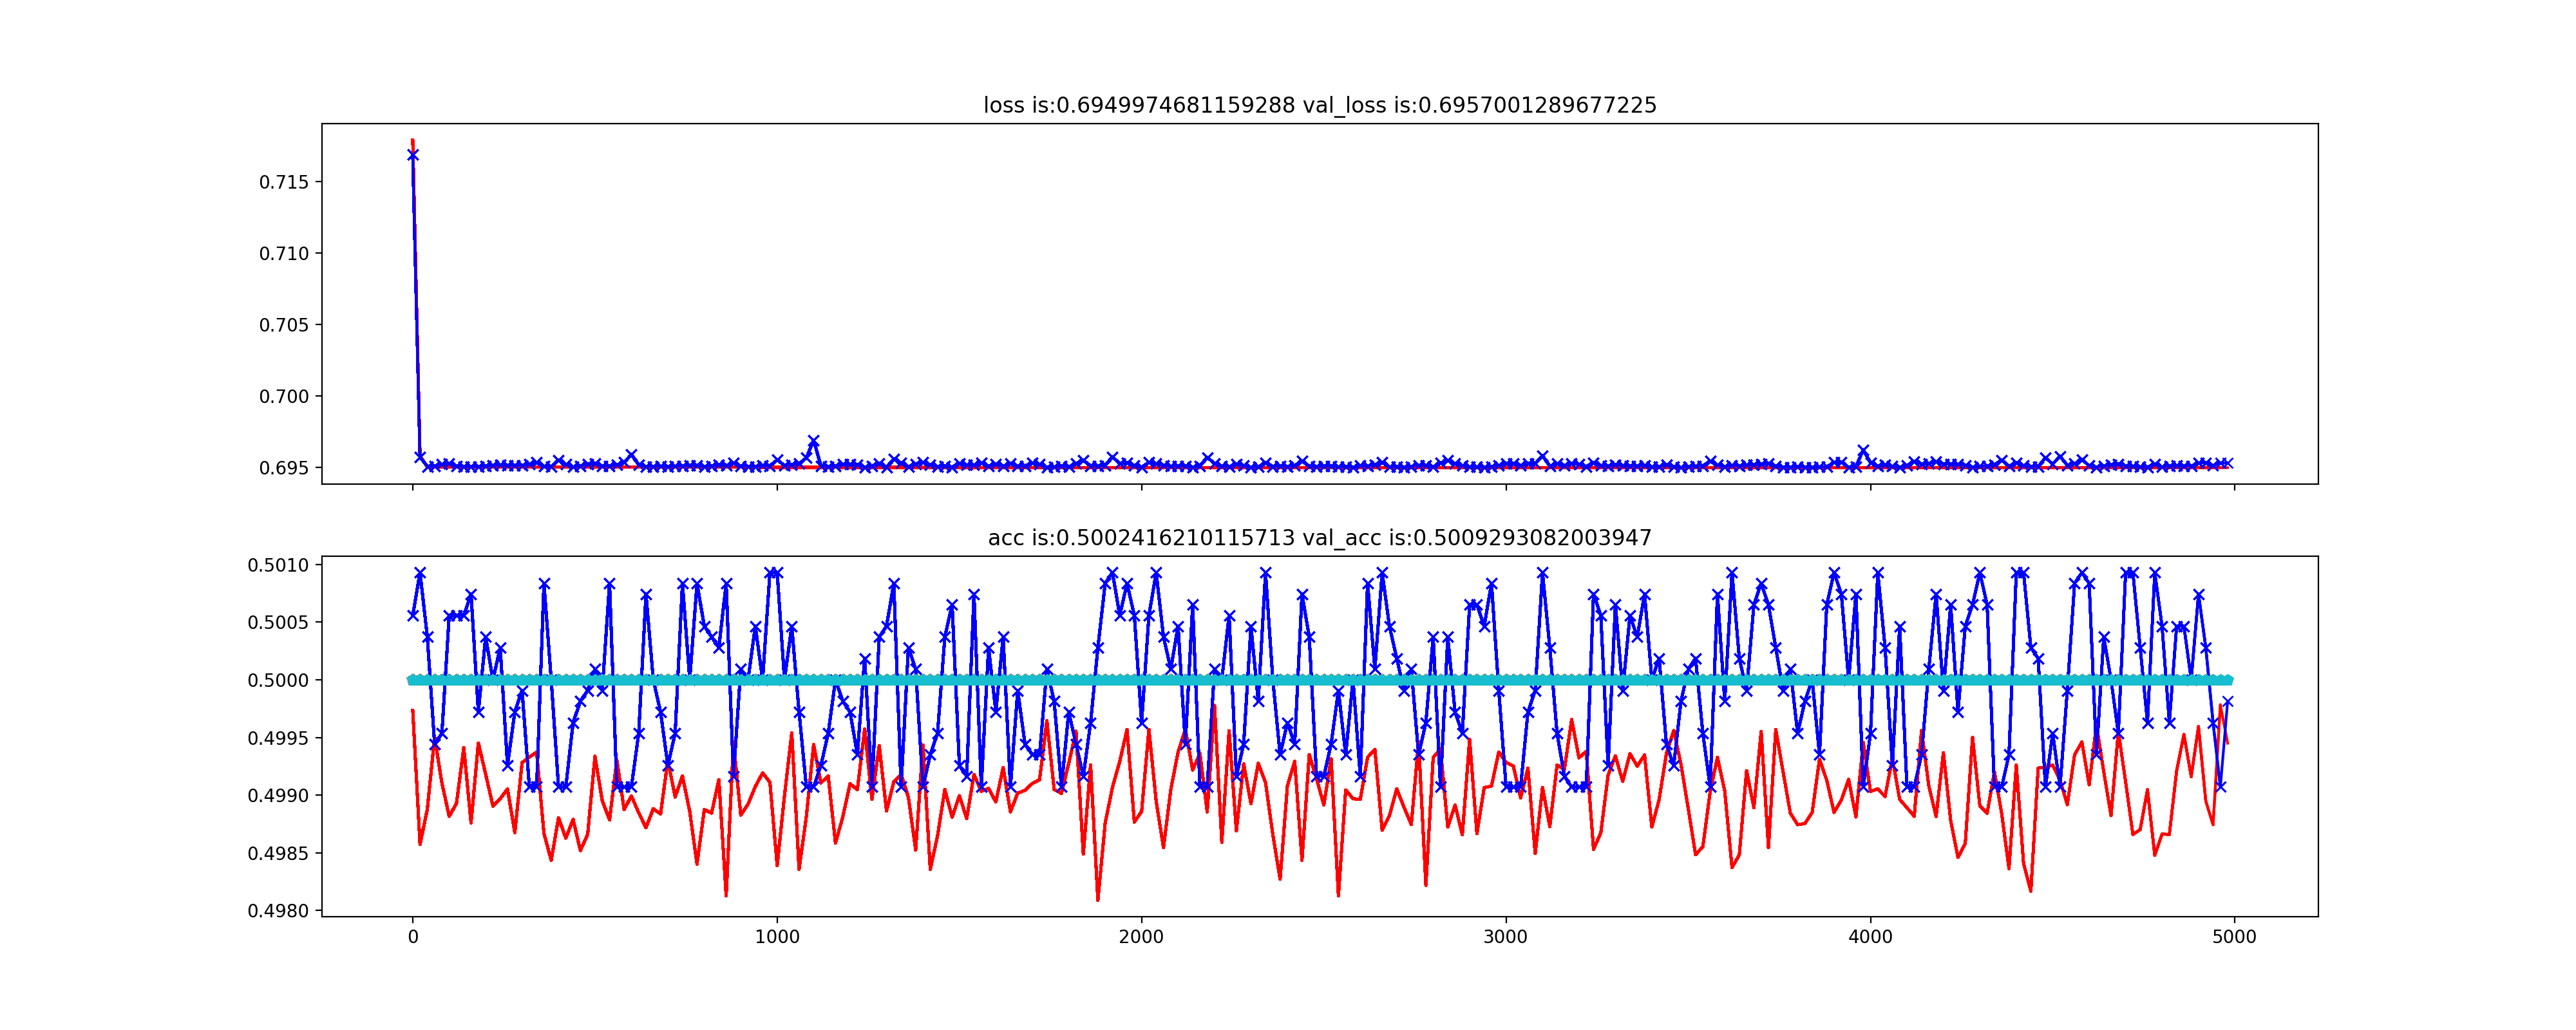

In [68]:
# configure network for training
num_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
print("model building finished\n", num_model.summary())

# do training
num_model.fit(trainX_num, trainY, epochs=5000, batch_size=5000, shuffle=True,
                  verbose=0, validation_data=[testX_num, testY], 
                  callbacks=[ReduceLROnPlateau(patience=10, min_lr=0.0001), VisualizeCallback])
num_model.save_weights("num_model_weights.h5")

In [59]:
# # debug only
# # generate model for descriptions
# model_input = Input(shape=(40,))
# x = model_input
# x = Embedding(input_dim=n_vacab, output_dim=256, input_length=40, name="embedding")(x)
# x = GaussianNoise(stddev=0.1)(x)
# x = Conv1D(filters=64, kernel_size=5, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Conv1D(filters=64, kernel_size=3, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = MaxPooling1D(pool_size=2)(x)
# x = Flatten()(x)
# x = Dense(64)(x)
# x = BatchNormalization()(x)
# x = Activation("sigmoid")(x)
# x = Dense(1, activation='sigmoid')(x)
# description_model = Model(inputs=[model_input], outputs=[x])

# # load pretrained embedding layer
# description_model.load_weights("embedding_layer_acc0.7512.h5", by_name=True)
# description_model.layers[1].trainable = False
# # configurate model training
# description_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
# print("model building finished\n", description_model.summary())

# # generate autoencoding model for num data
# model_input = Input(shape=(2,))
# x = model_input
# x = Dense(units=32, input_shape=(2,), name="num_dense_1")(x)
# x = BatchNormalization(name="num_bn_1")(x)
# x = Activation("tanh")(x)
# x = Dropout(0.25)(x)
# x = Dense(units=1, activation="sigmoid")(x)
# num_model = Model(inputs=[model_input], outputs=[x])

# # configure network for training
# num_model.compile(loss='mse', optimizer="adam", metrics=["mse"])
# print("model building finished\n", num_model.summary())

In [11]:
# load models from file
num_model.load_weights("num_model_weights.h5", by_name=True)
description_model.load_weights("description_model_weights.h5")
print("models weights loaded")

models weights loaded


In [84]:
# pop the original output layers including Activation and Dropout
# but we left BN layer there, not sure if it is helpful...
# for num_model
num_model.layers.pop()
num_model.layers.pop()
num_model.layers.pop()
num_output = num_model.layers[-1].output
num_model = Model(inputs=[num_model.layers[0].input], outputs=[num_output])
num_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

# for desc_model
description_model.layers.pop()
description_model.layers.pop()
description_model.layers.pop()
x = description_model.layers[-1].output
description_model = Model(inputs=[description_model.layers[0].input], outputs=[x])
description_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

print(num_model.summary())
print(description_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
num_dense_1 (Dense)          (None, 128)               384       
_________________________________________________________________
activation_19 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
num_dense_2 (Dense)          (None, 128)               16512     
_________________________________________________________________
num_bn_1 (BatchNormalization (None, 128)               512       
Total params: 17,408
Trainable params: 17,152
Non-trainable params: 256
_________________________________________________________________
None

In [85]:
# build hybrid model
# concatenate models in lower model and create upper model
hybrid_output = concatenate([num_model.layers[-1].output, description_model.layers[-1].output], axis=1)
hybrid_output = BatchNormalization()(hybrid_output) # This two layers is trying to normalize two output
hybrid_output = Activation("sigmoid")(hybrid_output) # And should alleviate the adaption effort when learning
upper_model = Model(inputs=[num_model.layers[0].input, description_model.layers[0].input], outputs=[hybrid_output])

# generate lower model
lower_input = Input(shape=(int(upper_model.layers[-1].output.shape[1]),))
lower_output = GaussianNoise(0.1)(lower_input)
lower_output = Dropout(0.25)(lower_output)

lower_output = Dense(units=256)(lower_output)
lower_output = BatchNormalization()(lower_output)
lower_output = Activation("tanh")(lower_output)
lower_output = Dropout(0.5)(lower_output)
lower_output = Dense(units=256)(lower_output)
lower_output = BatchNormalization()(lower_output)
lower_output = Activation("tanh")(lower_output)
lower_output = Dropout(0.5)(lower_output)
lower_output = Dense(units=2, activation="softmax")(lower_output)
# modelling low model
lower_model = Model(inputs=[lower_input], outputs=[lower_output])

# generate hybrid model
hybrid_model = Model(inputs=[num_model.layers[0].input, description_model.layers[0].input], # concatenated model have badly defined input
                         outputs=[lower_model(upper_model.layers[-1].output)])

# compile for training
upper_model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])
lower_model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])
hybrid_model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])
print("upper_model summary", upper_model.summary())
print("lower_model summary", lower_model.summary())
print("hybrid model summary\n", hybrid_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      3366912     input_5[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_9 (GaussianNoise (None, 35, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 35, 64)       82176       gaussian_noise_9[0][0]           
__________________________________________________________________________________________________
lstm_10 (L

In [35]:
# do lower model and upper model isolated training
# do rotating training
for i in range(6):
    if i%2 == 0:
        # freeze upper models
        for layer in upper_model.layers:
            layer.trainable = False
        for layer in lower_model.layers:
            layer.trainable = True
        hybrid_model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])
        print(hybrid_model.summary())
        print("in round {}, train lower_model only")
        
        # start training
        hybrid_model.fit([trainX_num, trainX_desc], trainY, epochs=5, batch_size=256, shuffle=True,
                      verbose=1, validation_data=[[testX_num, testX_desc], testY], callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=1)])
    else:
        # freeze lower models
        for layer in upper_model.layers:
            layer.trainable = True
        for layer in lower_model.layers:
            layer.trainable = False
        hybrid_model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])
        print(hybrid_model.summary())
        print("in round {}, train lower_model only")
        
        # start training
        hybrid_model.fit([trainX_num, trainX_desc], trainY, epochs=5, batch_size=256, shuffle=True,
                      verbose=1, validation_data=[[testX_num, testX_desc], testY], callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=1)])
    
# save model
filepath = "hybrid_model_weights.h5"
hybrid_model.save_weights(filepath)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      3366912     input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 35, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 35, 128)      197120      gaussian_noise_3[0][0]           
__________________________________________________________________________________________________
lstm_4 (LS

__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 128)          0           activation_4[0][0]               
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          16512       dropout_6[0][0]                  
__________________________________________________________________________________________________
num_dense_1 (Dense)             (None, 128)          384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 128)          512         dense_6[0][0]                    
__________

53504/53504 [==============================] - 51s 945us/step - loss: 0.3561 - acc: 0.8518 - val_loss: 0.9173 - val_acc: 0.6025
Epoch 2/5
53504/53504 [==============================] - 46s 860us/step - loss: 0.3393 - acc: 0.8588 - val_loss: 0.9202 - val_acc: 0.6017
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      3366912     input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 35, 256)      0           embedding[0][0]                  
_________________________________________

53504/53504 [==============================] - 52s 970us/step - loss: 0.2589 - acc: 0.8991 - val_loss: 1.1580 - val_acc: 0.5988
Epoch 2/5
17152/53504 [========>.....................] - ETA: 29s - loss: 0.2396 - acc: 0.9038

KeyboardInterrupt: 

In [36]:
# do overall training
# set layers to trainable
for layer in hybrid_model.layers:
    layer.trainable = True
hybrid_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics = ['accuracy'])
print(hybrid_model.summary())

# do fine_tuning
for i in range(1):
    hybrid_model.fit([trainX_num, trainX_desc], trainY, epochs=20, batch_size=256, shuffle=True,
                  verbose=1, validation_split=0.1, validation_data=[[testX_num, testX_desc], testY], callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)])
    # see actual result
    scores = hybrid_model.evaluate([testX_num, testX_desc], testY, verbose=1)
    print("Accuracy:{}".format(np.array(scores)))
    print("actual epoch num is: ", i)

# save model
filepath = "hybrid_model_weights.h5"
hybrid_model.save_weights(filepath)
print("weights saved")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      3366912     input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 35, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 35, 128)      197120      gaussian_noise_3[0][0]           
__________________________________________________________________________________________________
lstm_4 (LS

KeyboardInterrupt: 

In [20]:
# hybrid_model.load_weights("hybrid_model_weights.h5")
scores = hybrid_model.evaluate([testX_num, testX_desc], testY, verbose=1)
print("Accuracy:{}".format(np.array(scores)))

6727/6727 [==============================] - 2s 340us/step
Accuracy:[ 0.80829808  0.70209603]


In [21]:
zeros = 0.0
ones = 0.0
for i in testY:
    if i[0] == 0:
        zeros += 1
    else:
        ones += 1
print("frequency of zero is: ", zeros/(ones+zeros))

result = [1 if item[0] > item[1] else 0 for item in hybrid_model.predict_on_batch([testX_num, testX_desc])]
result = list(zip(result, list(zip(*testY))[0]))
predict_for_ones = np.array([1 for item in result if item[0] == item[1] and item[1] == 1])
right = float(len(predict_for_ones))
total = len([1 for item in result if item[0] == 1])
print("accurate prediction for 1 is: ",   right / total)
print("right guesses in all: ", right / len(result))
print("number of right is: ", right)

frequency of zero is:  0.48847926267281105
accurate prediction for 1 is:  0.6671318911374738
right guesses in all:  0.42634160844358554
number of right is:  2868.0
